In [23]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from scipy.stats import randint
import seaborn as sns

In [24]:
df = pd.read_csv('./LLCP2023_clean.csv', keep_default_na=False, dtype='category')

In [25]:
label_encoders = {}
for column in df.columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

In [26]:
X = df.drop(columns=['_MENT14D'])
y = df['_MENT14D']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [28]:
param_dist = {
    'n_estimators': randint(50, 100),
    'max_depth': randint(1, 20)
}

In [29]:
model = RandomForestClassifier(random_state=123)

In [30]:
rand_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

In [31]:
rand_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
                   n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c5d3cb16950>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c5cfb6000a0>},
                   random_state=42, scoring='accuracy', verbose=2)

In [32]:
best_model = rand_search.best_estimator_
print("Best hyperparameters:", rand_search.best_params_)

Best hyperparameters: {'max_depth': 12, 'n_estimators': 79}


In [33]:
joblib.dump(best_model, 'compressed_random_forest_model.pkl', compress=3)
print("Model saved to compressed_random_forest_model.pkl")

Model saved to compressed_random_forest_model.pkl


In [34]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovo')

    print("\nModel results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")

    print("\nDetailed classification report:")
    print(classification_report(y_test, y_pred))

    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'classification_report': classification_report(y_test, y_pred, output_dict=True)
    }

In [35]:
metrics = evaluate_model(best_model, X_test, y_test)


Model results:
Accuracy: 0.7042
F1 Score (weighted): 0.6982
ROC AUC Score: 0.8640

Detailed classification report:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73      7472
           1       0.70      0.48      0.57      3548
           2       0.70      0.80      0.74      5070

    accuracy                           0.70     16090
   macro avg       0.70      0.67      0.68     16090
weighted avg       0.70      0.70      0.70     16090



In [37]:
loaded_model = joblib.load('compressed_random_forest_model.pkl')


In [38]:
feature_importances = best_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'feature': features, 'importance': feature_importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

<ipython-input-39-b977dbeec39a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


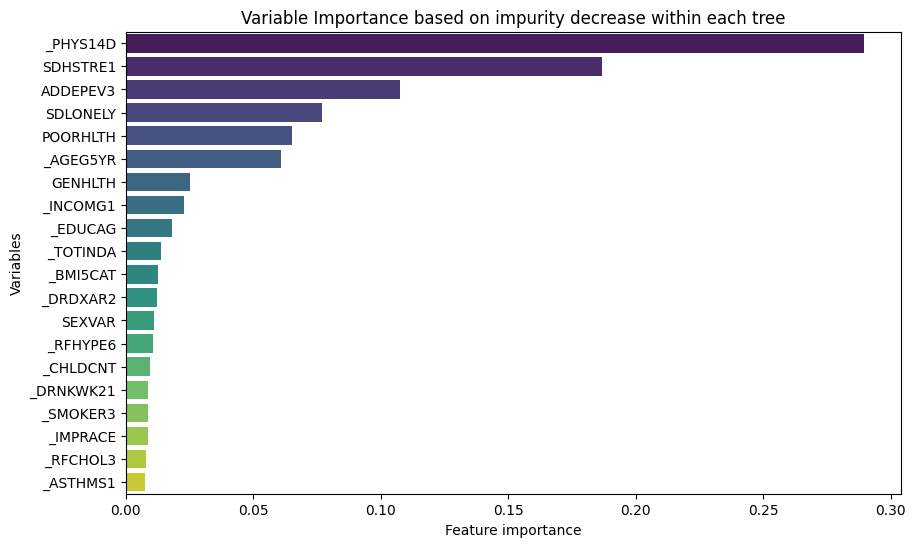

In [39]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x='importance',
    y='feature',
    data=importance_df.head(20),
    palette="viridis"
)

plt.title("Variable Importance based on impurity decrease within each tree")
plt.xlabel("Feature importance")
plt.ylabel("Variables")

plt.show()